In [1]:
%%bash
pip install gensim
pip install emoji --no-deps
pip install stopwordsiso

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.0 MB/s eta 0:00:00


## Import Libraries

In [2]:
import re
import string
import emoji
import pandas as pd
import nltk
import stopwordsiso
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from stopwordsiso import stopwords
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn import svm
import pickle
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
train = pd.read_csv('/kaggle/input/hasoc19-hindi-dataset/hindi_dataset.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/hasoc19-hindi-dataset/hasoc2019_hi_test_gold_2919.tsv', sep='\t')

train.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)
test.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [4]:
train.shape, test.shape

((4665, 2), (1318, 2))

## Data Pre-processing

In [5]:
def preprocess_hindi_text(df):
    """
    Preprocess Hindi text data in the 'text' column by:
    - Removing mentions (@USERS)
    - Removing hashtags
    - Removing URLs
    - Removing punctuation
    - Collapsing multiple spaces
    - Converting text to lowercase
    
    Parameters:
        df (pd.DataFrame): The dataset containing the 'text' column.
        
    Returns:
        pd.DataFrame: The processed dataset with the 'text' column cleaned.
    """
    # Removing @USER mentions
    df['text'] = df['text'].str.replace(r'@\w+\s*', '', regex=True)
    
    # Removing hashtags
    df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
    
    # Removing URLs
    df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    
    # Removing punctuation
    df['text'] = df['text'].str.replace(f'[{string.punctuation}]', '', regex=True)
    
    # Removing extra spaces
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Converting text to lowercase
    df['text'] = df['text'].str.lower()
    
    return df

def process_text_with_emojis(text):
    text_without_emojis = emoji.demojize(text)
    return text_without_emojis

In [6]:
train = preprocess_hindi_text(train)
test = preprocess_hindi_text(test)

train["text"] = train["text"].apply(process_text_with_emojis)
test["text"] = test["text"].apply(process_text_with_emojis)

In [7]:
train['text'] = train['text'].str.replace(r'।+', '', regex=True)
# Remove Digits
test['text'] = test['text'].str.replace(r'\d+', '', regex=True)

In [8]:
stopwordsiso.has_lang("hi")  # check if there is a stopwords for hindi language

True

In [9]:
# Load Hindi stopwords
marathi_stopwords = stopwords("hi")

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in marathi_stopwords]
    return ' '.join(filtered_words)

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [10]:
# Seperating hindi and english words
def insert_space(sentence):
    cleaned_sentence = re.sub(r'([a-zA-Z])([ऀ-ॿ]+)|([ऀ-ॿ]+)([a-zA-Z])', r'\1 \2\3 \4', sentence)
    return cleaned_sentence

train['text'] = train["text"].apply(insert_space)
test['text'] = test["text"].apply(insert_space)

In [11]:
# Replace multiple consecutive whitespace characters (spaces, tabs, newlines) with a single space
# Then, remove leading and trailing spaces from the text
train['text'] = train['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
test['text'] = test['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [12]:
train.head()

,text,label
0,बांग्लादेश शानदार वापसी भारत 314 रन रोका,0
1,सब रंडी नाच देखने व्यस्त ांतीदूत होगा सब ंडीरो...,1
2,तुम हरामियों बस जूतों कमी शुक्र तुम्हारी लिंचि...,1
3,बीजेपी mla आकाश विजयवर्गीय जेल रिहा जमानत मिलन...,0
4,चमकी बुखार विधानसभा परिसर आरजेडी प्रदर्शन तेजस...,0


In [13]:
test.head()

,text,label
0,वक्त इन्सान इंग्लैंड मौसम आपको कभी धोखा दे है।,0
1,ांग्रेस ीने ूत देखिए देश रक्षा ीद मां भारती ूत...,1
2,पाकिस्तान फेकना फेका गया। हार दुश्मन हरा दे हम...,1
3,शब्द तूम आज औरत यूज वो बचाकर रखना क्योंकि कल क...,0
4,नेता जी हम समाजवादी सिपाही हमेशा आपके आपका हर ...,0


## LSTM

In [14]:
# Parameters
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = 2

tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/hindi-bert-scratch")

def tokenize_texts(texts):
    return [torch.tensor(tokenizer.encode(text, truncation=True, max_length=MAX_LEN)) for text in texts]

# Prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42, stratify=train['label'])
test_texts, test_labels = test['text'], test['label']

train_tokens = tokenize_texts(train_texts)
val_tokens = tokenize_texts(val_texts)
test_tokens = tokenize_texts(test_texts)

# Label encoding
label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_labels))
val_labels = torch.tensor(label_encoder.transform(val_labels))
test_labels = torch.tensor(label_encoder.transform(test_labels))

tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/799k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [15]:
# Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

# Padding function
def collate_fn(batch):
    tokens, labels = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=tokenizer.pad_token_id)
    return tokens_padded, torch.tensor(labels)

# DataLoader
train_dataset = TextDataset(train_tokens, train_labels)
val_dataset = TextDataset(val_tokens, val_labels)
test_dataset = TextDataset(test_tokens, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [16]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return self.softmax(output)

# Initialize model
VOCAB_SIZE = tokenizer.vocab_size
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# Training Loop
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0

    for tokens, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(data_loader), total_correct / len(train_loader.dataset)

In [18]:
# Evaluation Function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for tokens, labels in data_loader:
            outputs = model(tokens)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            predictions.extend(outputs.argmax(1).tolist())
            true_labels.extend(labels.tolist())

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), predictions, true_labels

In [19]:
# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.6938, Train Accuracy: 0.5185
Val Loss: 0.6904, Val Accuracy: 0.5338
Epoch 2/10
Train Loss: 0.6910, Train Accuracy: 0.5332
Val Loss: 0.6885, Val Accuracy: 0.5413
Epoch 3/10
Train Loss: 0.6898, Train Accuracy: 0.5356
Val Loss: 0.6887, Val Accuracy: 0.5370
Epoch 4/10
Train Loss: 0.6360, Train Accuracy: 0.6420
Val Loss: 0.5774, Val Accuracy: 0.7299
Epoch 5/10
Train Loss: 0.5290, Train Accuracy: 0.7792
Val Loss: 0.5902, Val Accuracy: 0.7267
Epoch 6/10
Train Loss: 0.4856, Train Accuracy: 0.8266
Val Loss: 0.5844, Val Accuracy: 0.7256
Epoch 7/10
Train Loss: 0.4664, Train Accuracy: 0.8454
Val Loss: 0.5570, Val Accuracy: 0.7492
Epoch 8/10
Train Loss: 0.4336, Train Accuracy: 0.8794
Val Loss: 0.5278, Val Accuracy: 0.7899
Epoch 9/10
Train Loss: 0.4201, Train Accuracy: 0.8912
Val Loss: 0.5240, Val Accuracy: 0.7953
Epoch 10/10
Train Loss: 0.4081, Train Accuracy: 0.9035
Val Loss: 0.5358, Val Accuracy: 0.7856


Test Loss: 0.5560, Test Accuracy: 0.7466
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       713
           1       0.71      0.75      0.73       605

    accuracy                           0.75      1318
   macro avg       0.75      0.75      0.75      1318
weighted avg       0.75      0.75      0.75      1318



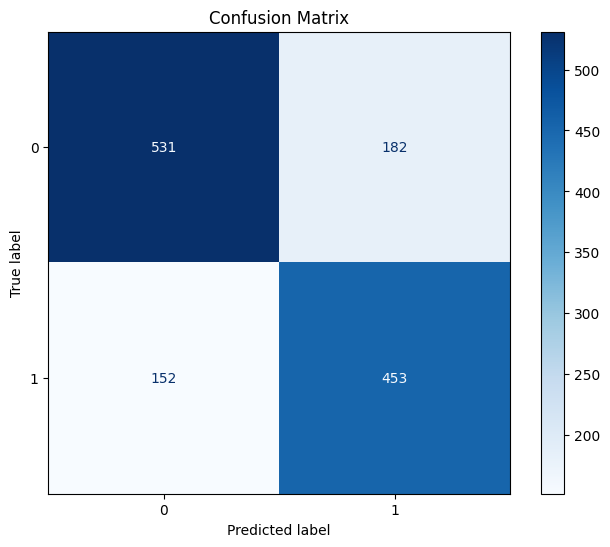

In [20]:
# Test Evaluation
test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification Report
class_names = [str(cls) for cls in label_encoder.classes_]  # Convert classes to strings
print(classification_report(test_true, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)

# Plot the confusion matrix with blue color
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

## LLM-Based Approach

### BERT English

In [21]:
# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['text'].tolist(), train['label'].tolist(), test_size=0.2, random_state=42, 
    stratify = train['label']
)

test_texts = test['text'].tolist()
test_labels = test['label'].tolist()

In [23]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 4. Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./bert_hate_speech_model')
tokenizer.save_pretrained('./bert_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.644800,0.627600,0.650589,0.622449,0.864372,0.723729
2,0.609200,0.532090,0.738478,0.741313,0.777328,0.758893
3,0.475700,0.440419,0.797428,0.855478,0.742915,0.795233


{'eval_loss': 0.4404185712337494, 'eval_accuracy': 0.797427652733119, 'eval_precision': 0.8554778554778555, 'eval_recall': 0.742914979757085, 'eval_f1': 0.7952329360780066, 'eval_runtime': 4.3047, 'eval_samples_per_second': 216.74, 'eval_steps_per_second': 1.858, 'epoch': 3.0}


Test Results: {'eval_loss': 0.4985214173793793, 'eval_accuracy': 0.7723823975720789, 'eval_precision': 0.7718360071301248, 'eval_recall': 0.715702479338843, 'eval_f1': 0.7427101200686107, 'eval_runtime': 6.0585, 'eval_samples_per_second': 217.547, 'eval_steps_per_second': 1.816, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.77      0.82      0.80       713
    Hate Speech       0.77      0.72      0.74       605

       accuracy                           0.77      1318
      macro avg       0.77      0.77      0.77      1318
   weighted avg       0.77      0.77      0.77      1318



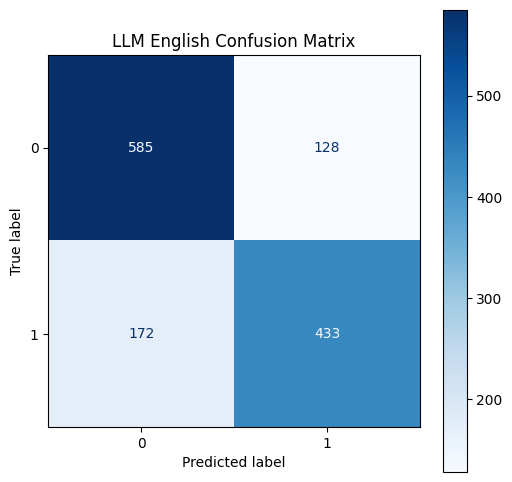

In [24]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()

### DistilBERT English

In [25]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
from torch.utils.data import Dataset

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./db_hate_speech_model')
tokenizer.save_pretrained('./db_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.661300,0.621133,0.659164,0.705607,0.611336,0.655098
2,0.617400,0.483805,0.775991,0.806452,0.759109,0.782065
3,0.421900,0.451878,0.801715,0.899225,0.704453,0.790011


{'eval_loss': 0.4518776834011078, 'eval_accuracy': 0.8017148981779206, 'eval_precision': 0.8992248062015504, 'eval_recall': 0.7044534412955465, 'eval_f1': 0.7900113507377979, 'eval_runtime': 2.2647, 'eval_samples_per_second': 411.975, 'eval_steps_per_second': 3.532, 'epoch': 3.0}


Test Results: {'eval_loss': 0.4742955267429352, 'eval_accuracy': 0.8088012139605463, 'eval_precision': 0.8522954091816367, 'eval_recall': 0.7057851239669422, 'eval_f1': 0.7721518987341772, 'eval_runtime': 3.1564, 'eval_samples_per_second': 417.565, 'eval_steps_per_second': 3.485, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.78      0.90      0.84       713
    Hate Speech       0.85      0.71      0.77       605

       accuracy                           0.81      1318
      macro avg       0.82      0.80      0.80      1318
   weighted avg       0.81      0.81      0.81      1318



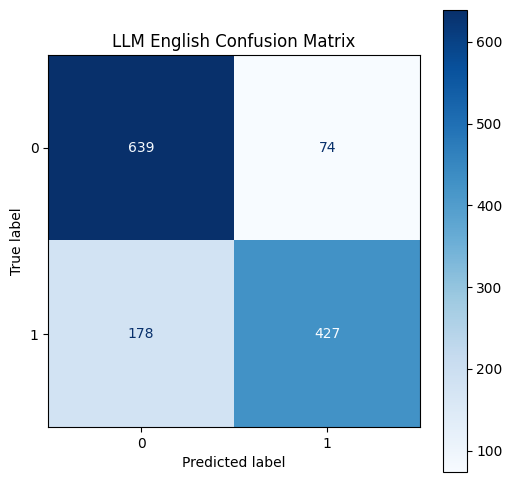

In [26]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()

### BERT HINDI

In [27]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("l3cube-pune/hindi-bert-scratch")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 4. Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = BertForSequenceClassification.from_pretrained("l3cube-pune/hindi-bert-scratch", num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./bert_hindi_hate_speech_model')
tokenizer.save_pretrained('./beri_hindi_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hindi-bert-scratch and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.384400,0.397949,0.813505,0.857143,0.777328,0.815287
2,0.459800,0.372666,0.825295,0.859002,0.801619,0.829319
3,0.299600,0.466913,0.832797,0.898585,0.771255,0.830065


{'eval_loss': 0.37266576290130615, 'eval_accuracy': 0.8252947481243301, 'eval_precision': 0.8590021691973969, 'eval_recall': 0.8016194331983806, 'eval_f1': 0.8293193717277486, 'eval_runtime': 3.3126, 'eval_samples_per_second': 281.654, 'eval_steps_per_second': 2.415, 'epoch': 3.0}


Test Results: {'eval_loss': 0.3951456844806671, 'eval_accuracy': 0.802731411229135, 'eval_precision': 0.7768860353130016, 'eval_recall': 0.8, 'eval_f1': 0.7882736156351792, 'eval_runtime': 6.0367, 'eval_samples_per_second': 218.332, 'eval_steps_per_second': 1.822, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.83      0.81      0.82       713
    Hate Speech       0.78      0.80      0.79       605

       accuracy                           0.80      1318
      macro avg       0.80      0.80      0.80      1318
   weighted avg       0.80      0.80      0.80      1318



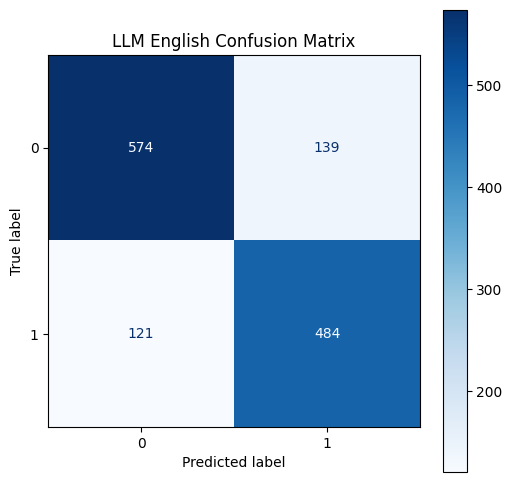

In [28]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()

### Multilingual DistilBERT

In [29]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
from torch.utils.data import Dataset

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./mdb_hate_speech_model')
tokenizer.save_pretrained('./mdb_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.579200,0.561888,0.719185,0.739669,0.724696,0.732106
2,0.530300,0.421004,0.812433,0.860045,0.771255,0.813234
3,0.383800,0.425724,0.814577,0.894349,0.736842,0.807991


{'eval_loss': 0.4210044741630554, 'eval_accuracy': 0.812433011789925, 'eval_precision': 0.8600451467268623, 'eval_recall': 0.771255060728745, 'eval_f1': 0.8132337246531484, 'eval_runtime': 2.4182, 'eval_samples_per_second': 385.829, 'eval_steps_per_second': 3.308, 'epoch': 3.0}


Test Results: {'eval_loss': 0.45443376898765564, 'eval_accuracy': 0.7966616084977238, 'eval_precision': 0.7851099830795262, 'eval_recall': 0.7669421487603306, 'eval_f1': 0.7759197324414715, 'eval_runtime': 3.3688, 'eval_samples_per_second': 391.232, 'eval_steps_per_second': 3.265, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.81      0.82      0.81       713
    Hate Speech       0.79      0.77      0.78       605

       accuracy                           0.80      1318
      macro avg       0.80      0.79      0.79      1318
   weighted avg       0.80      0.80      0.80      1318



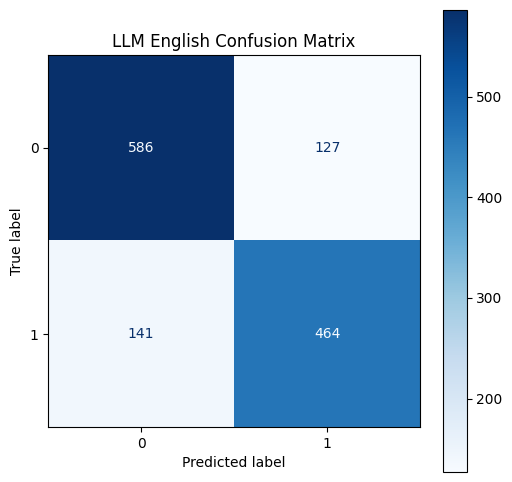

In [30]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()